## Importation des bliblothèques

In [78]:
import sqlite3
import pandas as pd

## Connection à la base de données

In [79]:
connect = sqlite3.connect("../../Databases/raw-database.db")
cursor = connect.cursor()

## Importation des données freeze frames

In [80]:
req = cursor.execute(f"SELECT frame, event_id, event_x, event_y, match_id_SKC, timestamp FROM freeze_frames")
res = req.fetchall()
desc = req.description
freeze_frames = pd.DataFrame(res)
freeze_frames.columns = [i[0] for i in desc]

In [81]:
# Aperçu des données
freeze_frames.head(3)

,frame,event_id,event_x,event_y,match_id_SKC,timestamp
0,4820,54cbad0c-1f05-4708-9b7f-2cadeae0636b,35.35,-27.71,1020089,2025-01-19 00:04:29
1,4834,28239a7e-4d65-4618-99f3-2763088e5e92,42.6125,-26.86,1020089,2025-01-19 00:04:30.400000
2,4854,3ea6ecd9-bc39-4ce5-9b47-1eda239f2705,44.1,1.615,1020089,2025-01-19 00:04:32.400000


## Importation des données events

In [82]:
# On récupère les event_id SB pour pouvoir importer uniquement ceux qui nous intéressent depuis la table events
event_id_freeze_frames = freeze_frames.event_id.unique().tolist()

In [83]:
req = cursor.execute(f"SELECT event_id, pass_cross, pass_type, team_id_SB FROM events WHERE event_id IN ({', '.join('?' * len(event_id_freeze_frames))})",
                     event_id_freeze_frames)
res = req.fetchall()
desc = req.description
events = pd.DataFrame(res)
events.columns = [i[0] for i in desc]

In [84]:
# Aperçu des données
events.head(3)

,event_id,pass_cross,pass_type,team_id_SB
0,2e85ad3e-59c4-479a-a478-4c98174f686b,NaN,None,156
1,872df8f3-a750-4b61-8890-61a35e96b4a4,1.0,None,147
2,0f842e18-1363-4af3-8faa-6c9cce55b118,NaN,None,147


## Jointure des events avec les freeze frames

In [85]:
freeze_frames_events = pd.merge(freeze_frames, events, on = "event_id")
freeze_frames_events.sort_values(by = ["match_id_SKC", "timestamp"], inplace = True)

In [86]:
# Aperçu des données
freeze_frames_events.head(3)

,frame,event_id,event_x,event_y,match_id_SKC,timestamp,pass_cross,pass_type,team_id_SB
0,4820,54cbad0c-1f05-4708-9b7f-2cadeae0636b,35.35,-27.71,1020089,2025-01-19 00:04:29,NaN,None,143
1,4834,28239a7e-4d65-4618-99f3-2763088e5e92,42.6125,-26.86,1020089,2025-01-19 00:04:30.400000,1.0,None,143
2,4854,3ea6ecd9-bc39-4ce5-9b47-1eda239f2705,44.1,1.615,1020089,2025-01-19 00:04:32.400000,NaN,None,143


La colonne "team_id_SB" contient donc l'id des équipes liées aux events.  
Étant donné que nous travaillons avec des données Skill Corner, il est plus logique de travailler avec les id SK des équipes.  
Nous allons donc faire matcher ces id SB avec les id SK grâce à la table de matching des équipes.

In [87]:
# Importation des données de matching entre les id Skill Corner et Stats Bomb des équipes
req = cursor.execute(f"SELECT * FROM matching_teams")
res = req.fetchall()
desc = req.description
matching_teams = pd.DataFrame(res)
matching_teams.columns = [i[0] for i in desc]

In [88]:
# Aperçu des données
matching_teams.head(2)

,team_id_SB,team_id_SKC
0,168,85
1,144,66


In [89]:
freeze_frames_events = pd.merge(freeze_frames_events, matching_teams, on = "team_id_SB")

In [90]:
freeze_frames_events.head(2)

,frame,event_id,event_x,event_y,match_id_SKC,timestamp,pass_cross,pass_type,team_id_SB,team_id_SKC
0,4820,54cbad0c-1f05-4708-9b7f-2cadeae0636b,35.35,-27.71,1020089,2025-01-19 00:04:29,NaN,None,143,78
1,4834,28239a7e-4d65-4618-99f3-2763088e5e92,42.6125,-26.86,1020089,2025-01-19 00:04:30.400000,1.0,None,143,78


In [91]:
# Nous pouvons supprimer la colonne "team_id_SB" qui ne nous est plus utile à présent
freeze_frames_events.drop("team_id_SB", axis = 1, inplace = True)

## Analyse des centres

In [92]:
# Création d'un dataframe ne comprenant que les centres du dataframe initial
centres = freeze_frames_events[freeze_frames_events.pass_cross == 1]

In [93]:
# On regarde si il y'a des valeurs centres qui sont présents plusieurs fois
# On utilise l'identifiant ["frame", "match_id_SKC"] qui permet d'identifier, de manière unique, chaque frame des données
centres[["frame", "match_id_SKC"]].duplicated().any()

np.False_

On souhaite maintenant identifier chaque centre et chaque évènement précédant un centre par un centre_id.  
Chaque couple (event précédant le centre, centre) sera alors identifié par un unique centre_id.  

De plus, on part du principe qu'on dispose bien de chaque évènement précédant les centres.  
En effet, étant donné que nous ne nous sommes pas chargé de fusionner les évènements précédant et suivant les centres aux évènements correspondant aux centres, nous ne pouvons pas gérer ces erreurs.

Pour gérer les cas ou l'évènement suivant un centre (centre1) est également un centre (centre2), nous partons du principe que ces centres ne sont pas dupliqués mais plutôt que ces centres se suivent en terme de frame.  
En effet, nous n'aurons pas 2 couples (event avant centre1, centre1, centre2) et (centre1, centre2, event après centre2) mais plutot un couple (event avant centre1, centre1, centre2, event après centre2)

In [94]:
# Nous partons de ce principe car nous n'avons pas de valeur dupliquée pour la colonne event_id :
print(freeze_frames_events.event_id.is_unique)

True


Enfin, il est nécessaire des supprimer les events correspondants à des coups de pied arretés car ce n'est pas cohérent d'étudier les évènements précédant des CPA.

In [95]:
# Liste des CPA définis par Stats Bomb
CPA = ["Corner", "Free Kick", "Goal Kick", "Kick Off"]

# Supression des CPA des centres
centres = centres[~centres.pass_type.isin(CPA)]

In [96]:
centres.head(2)

,frame,event_id,event_x,event_y,match_id_SKC,timestamp,pass_cross,pass_type,team_id_SKC
1,4834,28239a7e-4d65-4618-99f3-2763088e5e92,42.6125,-26.86,1020089,2025-01-19 00:04:30.400000,1.0,None,78
4,5755,d3b91062-3398-4235-8bbc-3571d2fd2d9c,-43.75,-29.24,1020089,2025-01-19 00:06:02.500000,1.0,None,70


In [97]:
# La colonne team_id_SKC contient donc les id SKC des équipes qui ont effectué les centres
# Nous allons renommer cette colonne "team_centre_id_SKC" pour bien indiquer qu'elle correspond aux équipes ayant effectué les centres
centres.rename({"team_id_SKC" : "team_centre_id_SKC"}, axis = 1, inplace = True)

print("Nombre de centres pour lesquels nous ne connaissons pas l'équipe qui les a effectués :", len(centres[centres.team_centre_id_SKC.isna()]))

Nombre de centres pour lesquels nous ne connaissons pas l'équipe qui les a effectués : 0


In [98]:
# identification des évènements précédant les centres
index_events_avant_centre = centres.index - 1

In [99]:
# Création d'un dataframe ne comprenant que les actions précédents les centres
events_avant_centre = freeze_frames_events.loc[index_events_avant_centre]

In [100]:
# On regarde si il y'a des évènements précédents des centres qui correspondent à des centres
events_avant_centre[events_avant_centre.pass_cross == 1]

,frame,event_id,event_x,event_y,match_id_SKC,timestamp,pass_cross,pass_type,team_id_SKC


In [101]:
# Autre moyen de vérifier
print(len(index_events_avant_centre.intersection(centres.index)))

0


Il n'y en a pas

In [102]:
# Attribution des centre_id à chaque events précédant les centres et à chaque centre
events_avant_centre["centre_id"] = range(len(events_avant_centre))
centres["centre_id"] = range(len(events_avant_centre))

In [103]:
# On attribue aux events précédant les centres l'équipe qui a effectué le centre (suivant ces events)
# En effet, il est possible que l'équipe en possession du ballon lors de l'évènement précédant un centre ne soit pas la même
# que celle qui a effectué le centre en question
# De ce fait, il est nécessaire de remplacer l'équipe actuellement attribuée aux events précédant les centres par les équipes ayant effectué 
# les centres
events_avant_centre.drop("team_id_SKC", axis = 1, inplace = True)
events_avant_centre = pd.merge(events_avant_centre, centres[["team_centre_id_SKC", "centre_id"]], on = "centre_id")

In [104]:
# Aperçu des données
events_avant_centre.head(2)

,frame,event_id,event_x,event_y,match_id_SKC,timestamp,pass_cross,pass_type,centre_id,team_centre_id_SKC
0,4820,54cbad0c-1f05-4708-9b7f-2cadeae0636b,35.35,-27.71,1020089,2025-01-19 00:04:29,NaN,None,0,78
1,5752,c1a7a598-9690-4a32-a733-b7b3b585df83,-43.4,-27.455,1020089,2025-01-19 00:06:02.200000,NaN,None,1,70


Nous avons terminé cette première étape qui nous a permis d'analyser et extraire les centres ainsi que les évènements les précédant.  
Nous obtenons finalement un dataframe composé de l'ensemble des events précédant les centres dont nous disposons.  
Ce dataframe contient des informations cruciales telles que la position de l'event ("event_x" et "event_y"), l'identifiant de la frame (le couple ["frame", "match_id_SKC"]) ou encore l'identifiant du centre que nous avons créé, dans le but de pouvoir retrouver le centre auquel correspond l'event précédant un centre.

Nous allons maintenant passer à l'analyse de la position des joueurs au moment de l'event précédant le centre.  
Pour cela, nous allons utiliser les données de tracking que nous avions au préalable importées dans la BDD SQLite grâce à nos programmes d'importation.

# Importation des données de tracking

In [105]:
req = cursor.execute(f"SELECT trackable_object, x, y, frame, match_id_SKC FROM tracking_data")
res = req.fetchall()
desc = req.description
tracking_data = pd.DataFrame(res)
tracking_data.columns = [i[0] for i in desc]

In [106]:
# Aperçu des données
tracking_data.head(2)

,trackable_object,x,y,frame,match_id_SKC
0,12235.0,45.43,-0.97,4820,1020089
1,12327.0,32.26,-2.78,4820,1020089


Nous allons maintenant fusionner le dataframe des events précédant les centres avec le dataframe des données de tracking.  
En effet, on souhaite étudier seulement les positions des joueurs sur les events précédant des centres, or le dataframe tracking_data actuel contient les données de toutes les frames disponibles.  
Pour effectuer ce merge, nous allons joindre les deux dataframes par rapport au couple ["match_id_SKC", "frame"] qui identifie de manière unique chaque frame.

In [107]:
td_avant_centre = pd.merge(events_avant_centre[["match_id_SKC", "frame", "centre_id", "team_centre_id_SKC", "event_x", "event_y"]], tracking_data, on = ["match_id_SKC", "frame"])
# td_avant_centre correspond à "tracking data des events avant les centres"

In [108]:
# Aperçu des données
td_avant_centre.head(2)

,match_id_SKC,frame,centre_id,team_centre_id_SKC,event_x,event_y,trackable_object,x,y
0,1020089,4820,0,78,35.35,-27.71,12235.0,45.43,-0.97
1,1020089,4820,0,78,35.35,-27.71,12327.0,32.26,-2.78


Nous allons maintenant regarder s'il y'a des frames (des events précédant les centres) pour lesquelles nous n'avons pas de tracking data

In [32]:
print("Nombre de centres pour lesquels nous n'avons pas d'information sur la frame de l'event précédent le centre dans les données de tracking :",
      len(events_avant_centre[~events_avant_centre.centre_id.isin(td_avant_centre.centre_id)]))
print("Nombre total de frames correspondant à des events précédant un centre :", len(events_avant_centre))

Nombre de centres pour lesquels nous n'avons pas d'information sur la frame de l'event précédent le centre dans les données de tracking : 38
Nombre total de frames correspondant à des events précédant un centre : 6181


On remarque qu'il y'a seulement 38 des 6181 frames pour lesquelles nous n'avons pas de données de tracking, ce qui reste raisonnablement faible.

---

Rappel : nous souhaitons étudier le nombre d'adversaires entre le ballon et le but pendant l'évènement précédant le centre.  
Or, pour l'instant, nous ne savons pas à quelles équipes appartiennent les joueurs (qui sont identifiés par la colonne "trackable_object").  
Dans la prochaine section, nous allons donc faire matcher les joueurs avec l'id SK de leur équipe

# Matching des joueurs avec leur équipe (pour chaque match)

Nous allons faire matcher, pour chaque match, l'ensemble des id Stats Bomb des joueurs présents sur la feuille de match avec l'id Skill Corner de leur équipe respectif.  
Il est important de bien s'intéresser aux id des joueurs pour chaque match et non sur une saison.  
En effet, dans le cas ou un joueur serait transféré d'une équipe à une autre au cours d'une saison, il aurait alors 2 valeurs (dans le cas ou on ferait matcher le joueur avec son équipe sur la saison)

Pour obtenir ce matching, nous allons utiliser les données lineup de Stats Bomb qui nous fournissent, pour chaque match, la liste des id des joueurs sur la feuille de match ainsi que les id SB des équipes auxquelles ils appartiennent.  
De plus, nous utiliserons les tables de matching pour les id SB et SK des matches, des équipes et des joueurs.

Rappel : nous avons déjà importé la table de matching des id SK et SB des équipes

In [33]:
# Importation des données de matching entre les id Skill Corner et Stats Bomb des matches
req = cursor.execute(f"SELECT * FROM matching_matches")
res = req.fetchall()
desc = req.description
matching_matches = pd.DataFrame(res)
matching_matches.columns = [i[0] for i in desc]

In [34]:
# Aperçu des données
matching_matches.head(2)

,match_id_SB,match_id_SKC
0,3894366.0,1547880
1,3894367.0,1547881


In [35]:
# Importation des données lineup de Stats Bomb.
req = cursor.execute(f"SELECT player_id_SB, team_id_SB, match_id_SB FROM lineups")
res = req.fetchall()
desc = req.description
lineups = pd.DataFrame(res)
lineups.columns = [i[0] for i in desc]

In [36]:
# Aperçu des données
lineups.head(2)

,player_id_SB,team_id_SB,match_id_SB
0,2941,147,3894037
1,3044,147,3894037


In [37]:
# Importation des données de matching des id SK et SB des joueurs.
# De plus, nous allons aussi importer la colonne "trackable_object" qui est utilisée pour identifier les joueurs dans les données de tracking
req = cursor.execute(f"SELECT trackable_object, player_id_SB, player_id_SKC FROM matching_players")
res = req.fetchall()
desc = req.description
matching_players = pd.DataFrame(res)
matching_players.columns = [i[0] for i in desc]

In [38]:
# Aperçu des données
matching_players.head(2)

,trackable_object,player_id_SB,player_id_SKC
0,820104,307251.0,818541
1,39010,66886.0,37889


Nous allons maintenant faire matcher les id SB des joueurs, des équipes et des matches avec leur id SK respectif

In [39]:
# Matching des id des matches
merge_match_id = pd.merge(lineups, matching_matches, on = "match_id_SB")

In [40]:
# Aperçu des données
merge_match_id.head(2)

,player_id_SB,team_id_SB,match_id_SB,match_id_SKC
0,2941,147,3894037,1020753
1,3044,147,3894037,1020753


In [41]:
# Matching des id des joueurs
merge_player_id = pd.merge(merge_match_id, matching_players, on = "player_id_SB")

In [42]:
# Aperçu des données
merge_player_id.head(2)

,player_id_SB,team_id_SB,match_id_SB,match_id_SKC,trackable_object,player_id_SKC
0,2941,147,3894037,1020753,11308,11274
1,3044,147,3894037,1020753,1743,1733


In [43]:
# Enfin, il ne nous reste plus qu'à faire matcher les id des équipes
matching_player_team = pd.merge(merge_player_id, matching_teams, on = "team_id_SB")

In [44]:
# Aperçu des données
matching_player_team.head(2)

,player_id_SB,team_id_SB,match_id_SB,match_id_SKC,trackable_object,player_id_SKC,team_id_SKC
0,2941,147,3894037,1020753,11308,11274,80
1,3044,147,3894037,1020753,1743,1733,80


Nous ne souhaitons conserver que les informations qui nous serons utiles pour le matching avec les données de tracking, c'est à dire les colonnes  "match_id_SKC", "trackable_object" et "team_id_SKC".

In [45]:
matching_player_team = matching_player_team[["match_id_SKC", "trackable_object", "team_id_SKC"]]

In [46]:
# De plus, nous renommons la colonne "team_id_SKC" par "team_player_id_SKC" afin d'éviter toute confusion
matching_player_team.rename({"team_id_SKC" : "team_player_id_SKC"}, axis = 1, inplace = True)

---

Nous avons maintenant terminé de créer les données de matching nécessaire, nous allons donc les appliquer aux données de tracking.

In [47]:
# Rappel données de tracking
td_avant_centre.head(2)

,match_id_SKC,frame,centre_id,team_centre_id_SKC,event_x,event_y,trackable_object,x,y
0,1020089,4820,0,78,35.35,-27.71,12235.0,45.43,-0.97
1,1020089,4820,0,78,35.35,-27.71,12327.0,32.26,-2.78


Nous allons faire matcher les joueurs avec leur équipe

In [48]:
# Nous rajoutons le paramètre : how = "left" afin d'effectuer un "left join" SQL.
# En effet, les données de tracking contiennent aussi des informations sur le ballon, qui ne possède pas d'équipe.
# En effectuant un inner join (qui est la jointure effectuée par défaut par la commande merge de Pandas), cela ne gardera pas les données de
# tracking du ballon car il n'est pas référencé dans les données de matching_player_team
tracking_data = pd.merge(td_avant_centre, matching_player_team, on = ["match_id_SKC", "trackable_object"], how = "left")
# Nous nommons ce dataframe tracking_data car c'est le dataframe final

In [49]:
# Aperçu des données
tracking_data.head(2)

,match_id_SKC,frame,centre_id,team_centre_id_SKC,event_x,event_y,trackable_object,x,y,team_player_id_SKC
0,1020089,4820,0,78,35.35,-27.71,12235.0,45.43,-0.97,70.0
1,1020089,4820,0,78,35.35,-27.71,12327.0,32.26,-2.78,70.0


In [50]:
# Colonnes pour lesquelles on a des données manquantes
tracking_data.isna().any()

match_id_SKC          False
frame                 False
centre_id             False
team_centre_id_SKC    False
event_x               False
event_y               False
trackable_object      False
x                     False
y                     False
team_player_id_SKC     True
dtype: bool

On peut voir qu'il y'a des joueurs pour lesquels nous ne connaissons pas l'id SK de leur équipe (pour un ou plusieurs matchs).  

In [51]:
# On regarde les joueurs (trackable_object) dont on ne connait pas leur équipe sur un match
tracking_data[tracking_data.team_player_id_SKC.isna()].trackable_object.drop_duplicates()

22            55.0
2287       32283.0
50068     797972.0
94856     812065.0
103244     93910.0
128384    818917.0
158409    828435.0
Name: trackable_object, dtype: float64

On remarque qu'il y'a le trackable_object 55, qui correspond au ballon, c'est donc normal qu'on ne connaisse pas son équipe

In [52]:
# On regarde le nombre de tracks liées à des joueurs dont on ne connait pas l'id SK de leur équipe pour le match en question
nb_tracks_team_na = len(tracking_data[(tracking_data.team_player_id_SKC.isna()) & (tracking_data.trackable_object != 55)])
print("Nombre de tracks liées à des joueurs dont on ne connait pas l'id SK de leur équipe pour le match en question :", nb_tracks_team_na)
print("Ratio par rapport au nombre total de tracks disponibles :", round(nb_tracks_team_na*100/len(tracking_data), 2), "%")

Nombre de tracks liées à des joueurs dont on ne connait pas l'id SK de leur équipe pour le match en question : 550
Ratio par rapport au nombre total de tracks disponibles : 0.34 %


Il n'y a que 550 tracks qui correspondent à ce cas, ce qui est minoritaire par rapport au nombre de tracks disponibles

In [53]:
# On décide donc de retirer ces tracks du dataframe
# Cependant, il faut bien faire attention à ne pas retirer les tracks du ballon (trackable object 55)
tracking_data = tracking_data[(~tracking_data.team_player_id_SKC.isna()) | (tracking_data.trackable_object == 55)]

---
Nous pouvons maintenant passer à la dernière partie qui concerne à étudier la position des joueurs adverses (à l'équipe qui a centré) lors de l'évènement précédant le centre.  

# Étude de la position des adversaires lors de l'action précédant le centre

Nous allons regarder pour chaque centre, le nombre d'adversaires entre le ballon et le but.  
Pour cela, nous allons entre autre nous servir de la variable centre_id qui permet d'identifier de manière unique chaque centre disponible.  
Nous souhaitons donc étudier uniquement les tracks liées au joueur pour lesquels l'id SK de leur équipe est différent de l'id SK de l'équipe ayant effectué le centre

In [54]:
# Nous récupérons toutes les tracks liées au ballon
positions_ballon = tracking_data[tracking_data.trackable_object == 55]

In [55]:
# Nous gardons seulement les adversaires de l'équipe qui a centré
# Il faut bien penser à ne pas prendre les tracks liées au ballon 
tracking_data_adv = tracking_data[(tracking_data.team_centre_id_SKC != tracking_data.team_player_id_SKC) & (tracking_data.trackable_object != 55)]

In [56]:
# On regarde s'il y a des tracks liées au ballon pour lesquels on a aucun track de joueur adverse (par rapport au centre_id)
positions_ballon[~positions_ballon.centre_id.isin(tracking_data_adv.centre_id)]

,match_id_SKC,frame,centre_id,team_centre_id_SKC,event_x,event_y,trackable_object,x,y,team_player_id_SKC


In [57]:
# Et inversement, s'il y a des tracks de joueurs adverses pour lesquels on n'a pas de track de ballon associé
tracking_data_adv[~tracking_data_adv.centre_id.isin(positions_ballon.centre_id)]

,match_id_SKC,frame,centre_id,team_centre_id_SKC,event_x,event_y,trackable_object,x,y,team_player_id_SKC


In [111]:
# Pour pouvoir facilement détecter la position des joueurs adverses par rapport au ballon, nous allons ajouter à chaque ligne la position du ballon
# lors de l'event précédant un centre auquel la ligne fait référence.
# Pour ce faire, nous allons effectuer une jointure au niveau du centre_id
tracking_data_adv = pd.merge(tracking_data_adv, positions_ballon[["centre_id", "x", "y"]], on = "centre_id", suffixes = (None, "_ballon"))

In [112]:
# Aperçu des données
tracking_data_adv.head(3)

,match_id_SKC,frame,centre_id,team_centre_id_SKC,event_x,event_y,trackable_object,x,y,team_player_id_SKC,x_ballon,y_ballon
0,1020089,4820,0,78,35.35,-27.71,12235.0,45.43,-0.97,70.0,32.96,-28.64
1,1020089,4820,0,78,35.35,-27.71,12327.0,32.26,-2.78,70.0,32.96,-28.64
2,1020089,4820,0,78,35.35,-27.71,2340.0,33.55,-16.15,70.0,32.96,-28.64


In [59]:
positions_ballon.x.sort_values()

107428   -55.71
11635    -53.67
13394    -53.49
27018    -53.27
136665   -52.70
          ...  
620       52.98
130374    53.11
130351    53.11
34651     53.77
42552     54.49
Name: x, Length: 6993, dtype: float64

In [60]:
positions_ballon.y.sort_values()

46416    -37.57
11106    -35.83
138666   -35.32
109061   -35.27
45933    -35.10
          ...  
71641     34.50
89802     34.56
126165    34.69
42552     35.39
46439     35.69
Name: y, Length: 6993, dtype: float64

In [61]:
df_test = pd.read_json("../../Importation/Projet_centres_data/data_add/SKC_matches_data_2.json")

In [62]:
df_test

,1547880,1547881,1547882,1547883,1547884,1547885,1547886,1547887,1547888,1536669,...,1034262,1024091,1023376,1022715,1023377,1028727,1022717,1021411,1020753,1020089
0,left_to_right,right_to_left,right_to_left,left_to_right,left_to_right,right_to_left,right_to_left,right_to_left,right_to_left,right_to_left,...,left_to_right,left_to_right,right_to_left,right_to_left,right_to_left,left_to_right,right_to_left,right_to_left,left_to_right,right_to_left
1,right_to_left,left_to_right,left_to_right,right_to_left,right_to_left,left_to_right,left_to_right,left_to_right,left_to_right,left_to_right,...,right_to_left,right_to_left,left_to_right,left_to_right,left_to_right,right_to_left,left_to_right,left_to_right,right_to_left,left_to_right


In [75]:
tracking_data_adv[tracking_data_adv.centre_id == 1]

,match_id_SKC,frame,centre_id,team_centre_id_SKC,event_x,event_y,trackable_object,x,y,team_player_id_SKC


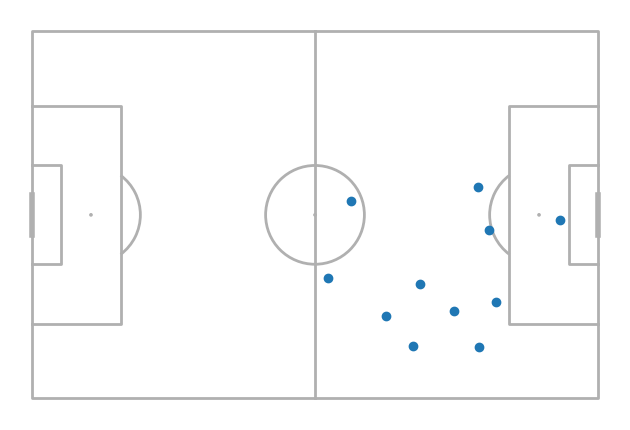

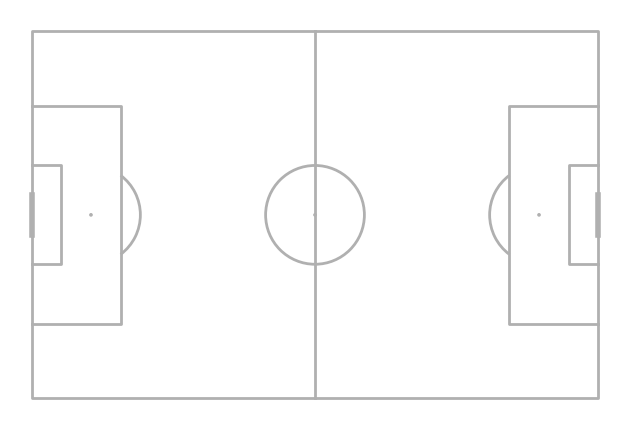

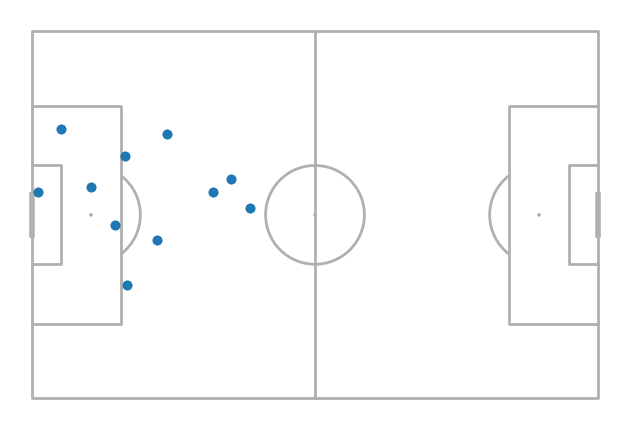

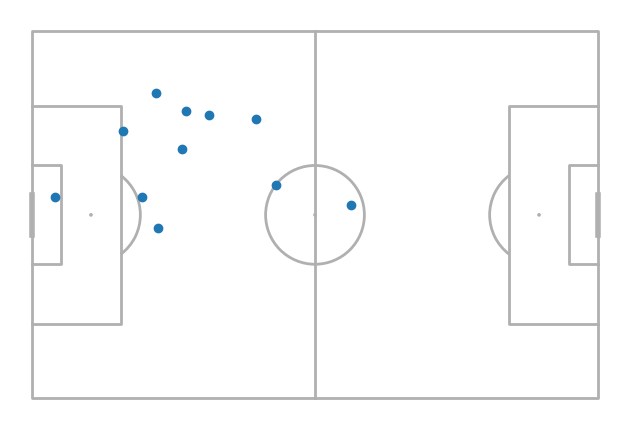

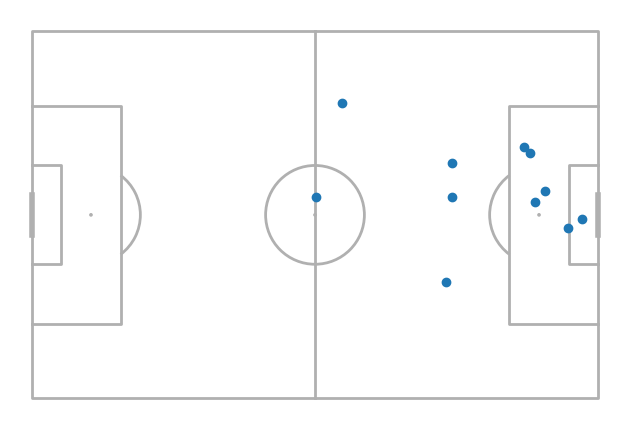

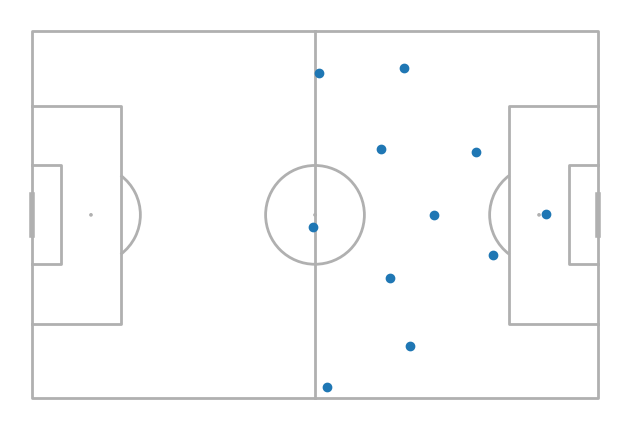

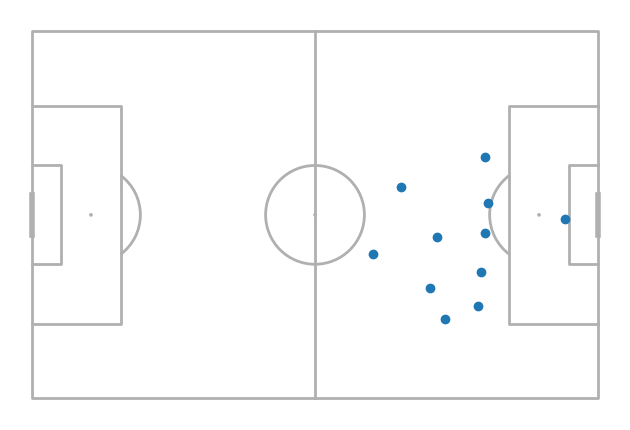

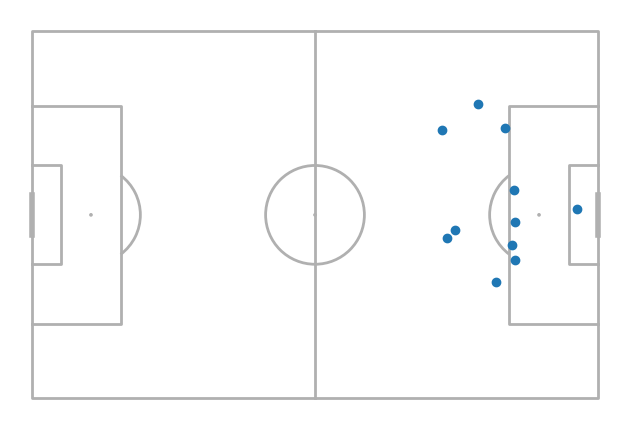

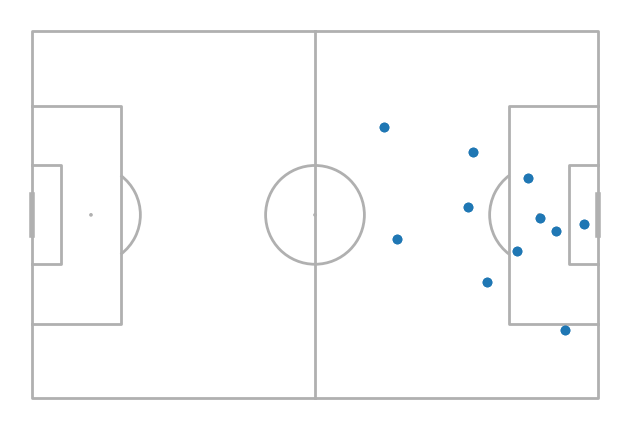

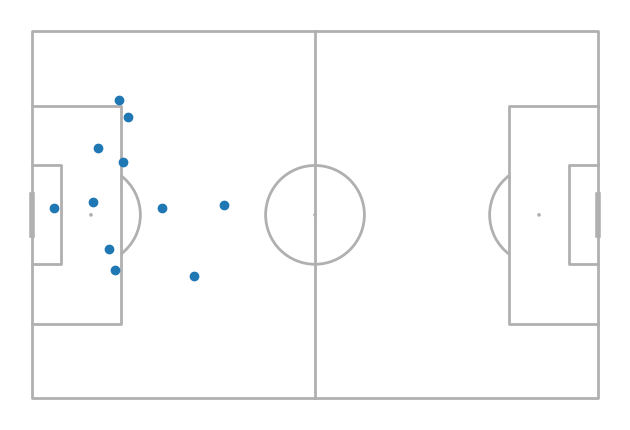

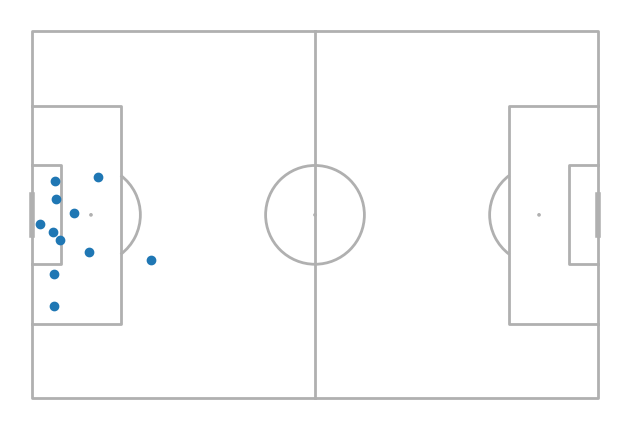

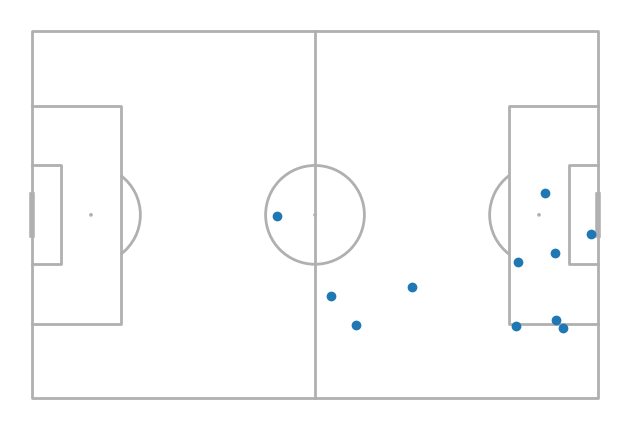

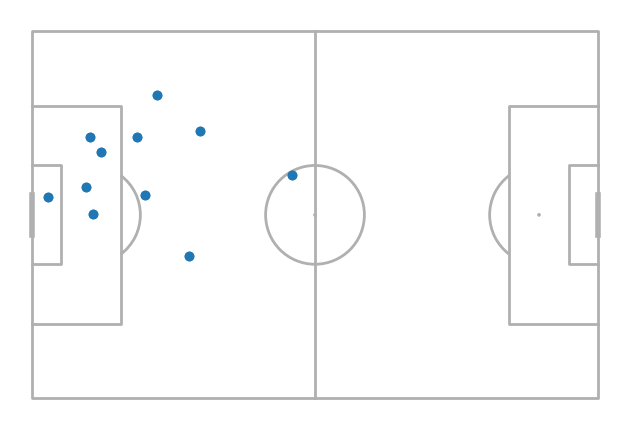

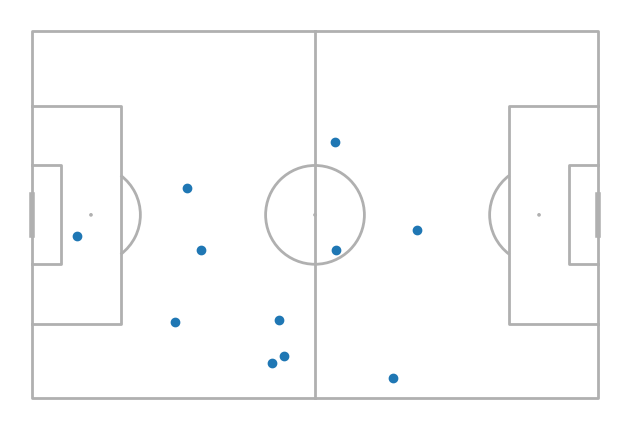

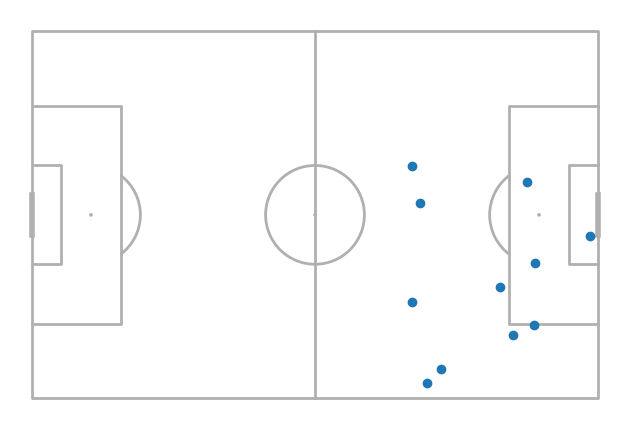

In [77]:
from mplsoccer import Pitch
pitch = Pitch(pitch_type = "skillcorner", pitch_length = 105, pitch_width = 68)
for i in range (15) :
    fig, ax = pitch.draw()
    pitch.scatter(tracking_data_adv[tracking_data_adv.centre_id == i][["x"]], tracking_data_adv[tracking_data_adv.centre_id == i][["y"]], ax = ax)